##### Use of mulitiple outputs can be considered as a regularization method. For example, you may want to add some auxiliary outputs in a neural network architecture to ensure that the underlying path of the network learns something useful on its own, without relying on the rest of the network

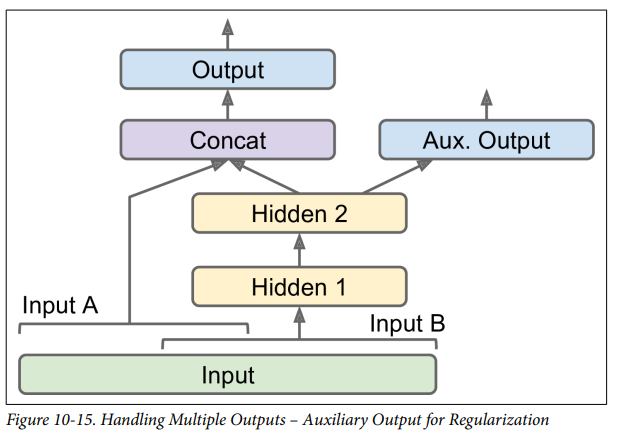

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
## IMPORTS
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
housing = fetch_california_housing()

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

There are total of 8 features in the dataset. So let's send 0 to 4 to first input and from 2 to 7 to the second input

In [7]:
## creating a model
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='auxiliary_output')(hidden2)

model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

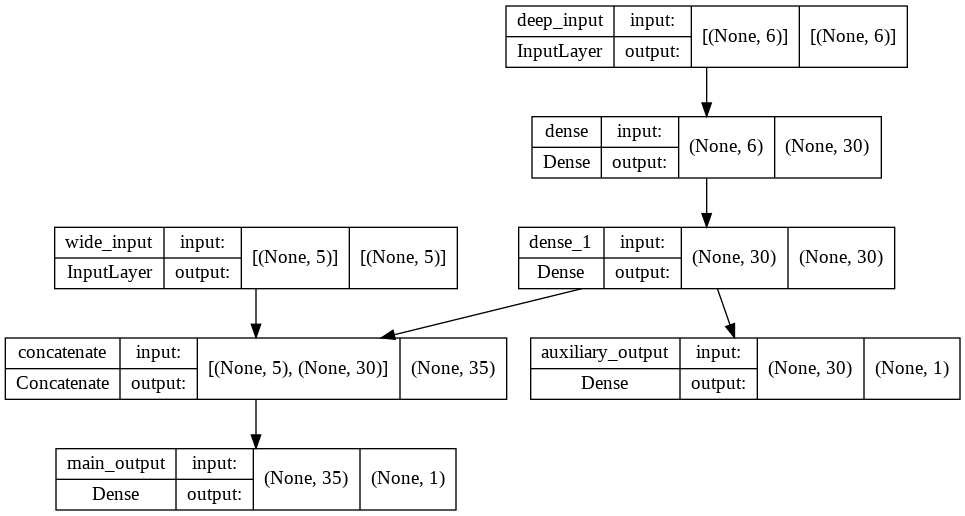

In [8]:
## visualizing the created model
keras.utils.plot_model(model, show_shapes=True)

##### Each output will need its own loss function. Therefore, when we compile the model, we should pass a list of losses (If we pass a single loss, keras will assume that the same loss must be used for all outputs). Alternatively, you can pass a dictionary that maps each output name to the corresponding loss. Just like for the inputs, this is useful when there are multiple outputs, to avoid getting the order wrong. The loss weights and metrics can also be set using dictionaries. 

##### By default, keras will compute all these losses and simply add them up to get the final loss used for training. 
##### We care much more about the main output than the auxiliary output (as it is just used for regularization), so we want to give the main output's loss a much greater weight.

In [9]:
## compiling the model
loss_dict = dict()
loss_dict['main_output'] = 'mse'
loss_dict['auxiliary_output'] = 'mse'

model.compile(loss=loss_dict, loss_weights=[0.9,0.1], optimizer='sgd')

In [10]:
## getting the training and testing and validation data for the inputs

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

In [11]:
## fitting the model to the data
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data = ([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 0.9472 - main_output_loss: 0.8585 - auxiliary_output_loss: 1.7451 - val_loss: 0.6706 - val_main_output_loss: 0.6039 - val_auxiliary_output_loss: 1.2707
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5641 - main_output_loss: 0.5121 - auxiliary_output_loss: 1.0319 - val_loss: 0.5586 - val_main_output_loss: 0.5107 - val_auxiliary_output_loss: 0.9895
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4970 - main_output_loss: 0.4604 - auxiliary_output_loss: 0.8261 - val_loss: 0.5187 - val_main_output_loss: 0.4840 - val_auxiliary_output_loss: 0.8314
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4636 - main_output_loss: 0.4351 - auxiliary_output_loss: 0.7198 - val_loss: 0.5524 - val_main_output_loss: 0.5306 - val_auxiliary_output_loss: 0.7482
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4448 - main_output_l

In [12]:
## creating a history dataframe
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,main_output_loss,auxiliary_output_loss,val_loss,val_main_output_loss,val_auxiliary_output_loss
0,0.947179,0.858522,1.745095,0.670614,0.603941,1.270667
1,0.564063,0.512084,1.031881,0.558582,0.510702,0.989502
2,0.496971,0.460405,0.826057,0.518710,0.483963,0.831434
3,0.463614,0.435147,0.719815,0.552356,0.530596,0.748196
4,0.444839,0.420588,0.663092,0.509587,0.488026,0.703640


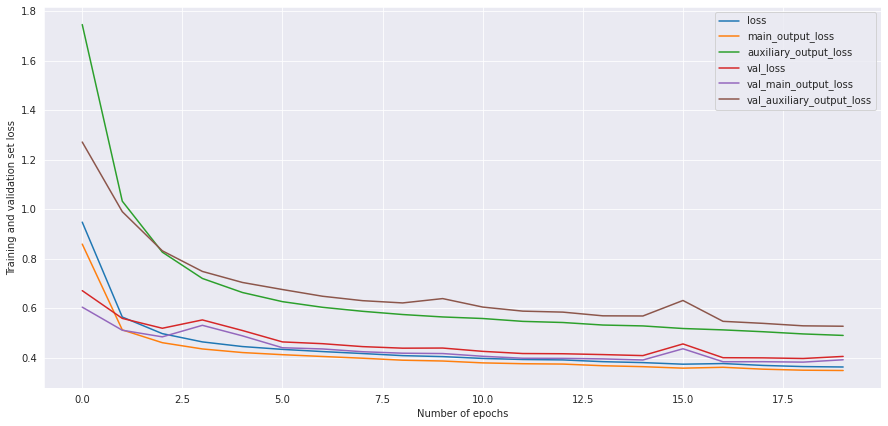

In [13]:
## plotting the loss 
sns.set_style('darkgrid')
history_df.plot(figsize=(15,7))
plt.grid(True)
plt.xlabel('Number of epochs')
plt.ylabel('Training and validation set loss')
plt.show();

In [14]:
## evaluating a model on test data
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.3766 - main_output_loss: 0.3639 - auxiliary_output_loss: 0.4908


In [15]:
import numpy as np

print(f"Total loss on the test data: {np.round(total_loss,3)}")
print(f"Loss on the main output on test data: {np.round(main_loss,3)}")
print(f"Loss on the auxiliary output on test data: {np.round(aux_loss,3)}")

Total loss on the test data: 0.377
Loss on the main output on test data: 0.364
Loss on the auxiliary output on test data: 0.491


In [16]:
## since we don't have any new data for prediction, we will use some of the rows from X_test as a new data
X_new_A, X_new_B = X_test_A[3:10], X_test_B[3:10] 

In [17]:
## prediction on the new data
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

In [18]:
y_pred_main

array([[1.8364123],
       [1.3713237],
       [1.1075019],
       [1.9520186],
       [1.9990952],
       [3.2205527],
       [2.6611178]], dtype=float32)

In [19]:
y_test[3:10]

array([1.057, 1.297, 0.871, 2.161, 2.188, 2.213, 2.871])

In [20]:
y_pred_aux

array([[2.4111795],
       [1.7123641],
       [1.0745068],
       [2.1344943],
       [1.7451261],
       [3.453222 ],
       [2.9172642]], dtype=float32)

In [21]:
y_test[3:10]

array([1.057, 1.297, 0.871, 2.161, 2.188, 2.213, 2.871])